# New Section

<ipython-input-20-6b38ec3cb251>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep_day['SleepDay'] = pd.to_datetime(sleep_day['SleepDay'])
<ipython-input-20-6b38ec3cb251>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weight_log_info['Date'] = pd.to_datetime(weight_log_info['Date'])


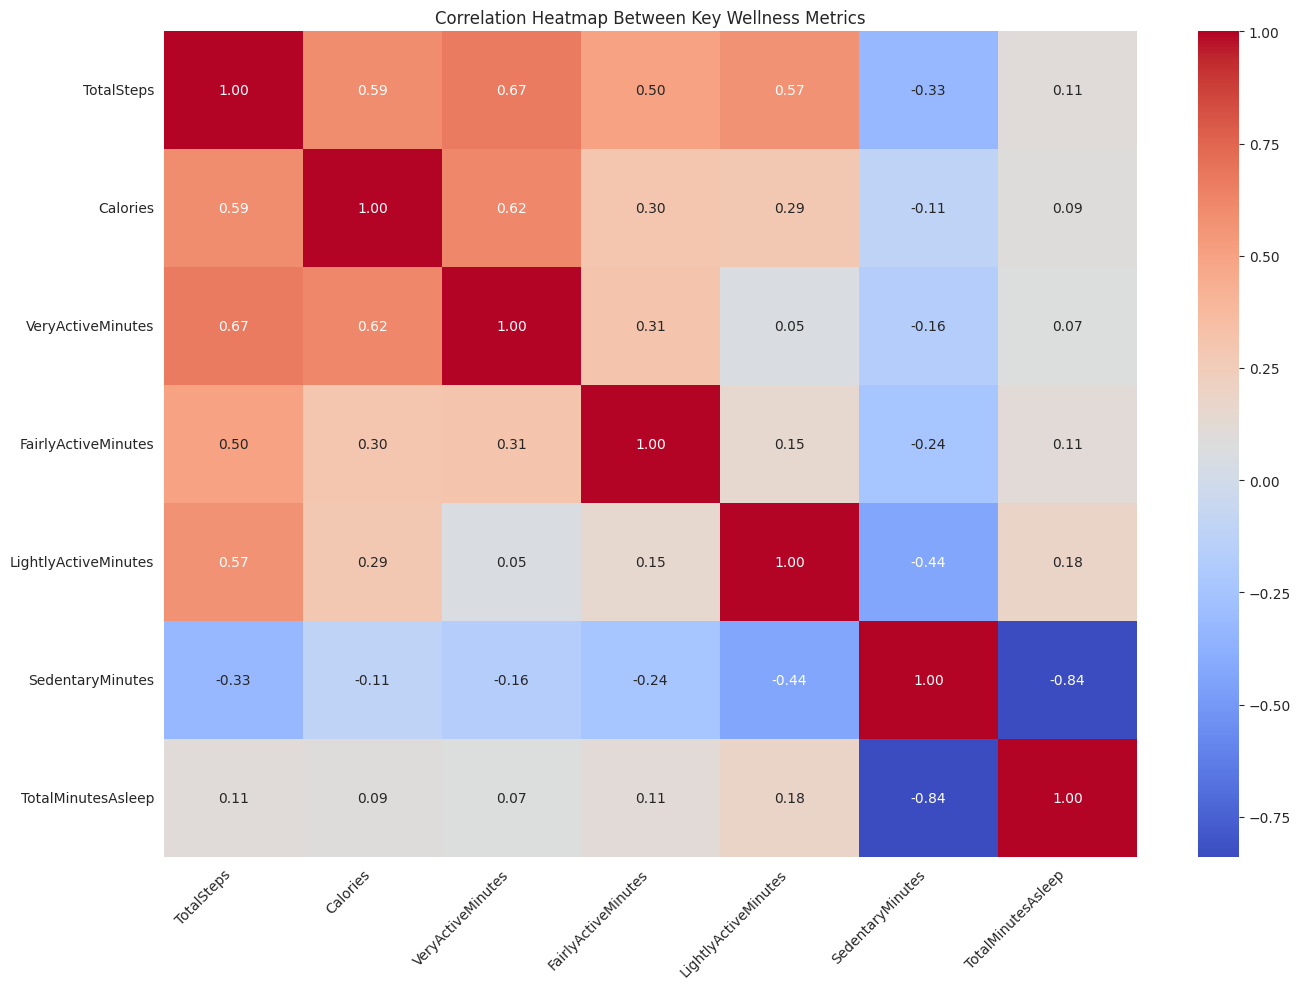

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------------------------------------------------------
# 1. Set up Seaborn style for all plots
# ------------------------------------------------------------------------------
sns.set_style("whitegrid")

# ------------------------------------------------------------------------------
# 2. Load datasets (adjust paths if needed)
# ------------------------------------------------------------------------------
paths = '/content/'
daily_activity = pd.read_csv(paths + 'dailyActivity_merged.csv')
daily_calories = pd.read_csv(paths + 'dailyCalories_merged.csv')
daily_steps = pd.read_csv(paths + 'dailySteps_merged.csv')
daily_intensities = pd.read_csv(paths + 'dailyIntensities_merged.csv')
sleep_day = pd.read_csv(paths + 'sleepDay_merged.csv')
weight_log_info = pd.read_csv(paths + 'weightLogInfo_merged.csv')

# ------------------------------------------------------------------------------
# 3. Convert relevant columns to datetime
# ------------------------------------------------------------------------------
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'])
daily_calories['ActivityDay'] = pd.to_datetime(daily_calories['ActivityDay'])
daily_steps['ActivityDay'] = pd.to_datetime(daily_steps['ActivityDay'])
daily_intensities['ActivityDay'] = pd.to_datetime(daily_intensities['ActivityDay'])
sleep_day['SleepDay'] = pd.to_datetime(sleep_day['SleepDay'])
weight_log_info['Date'] = pd.to_datetime(weight_log_info['Date'])

# ------------------------------------------------------------------------------
# 4. Remove duplicates within each dataframe
# ------------------------------------------------------------------------------
for df in [
    daily_activity, daily_calories, daily_steps,
    daily_intensities, sleep_day, weight_log_info
]:
    df.drop_duplicates(inplace=True)

# ------------------------------------------------------------------------------
# 5. Merge datasets on matching keys
# ------------------------------------------------------------------------------
merged_df = daily_activity.merge(
    daily_calories, left_on=['Id', 'ActivityDate'],
    right_on=['Id', 'ActivityDay'], how='inner'
)
merged_df = merged_df.merge(
    daily_steps, left_on=['Id', 'ActivityDate'],
    right_on=['Id', 'ActivityDay'], suffixes=('', '_steps'), how='inner'
)
merged_df = merged_df.merge(
    daily_intensities, left_on=['Id', 'ActivityDate'],
    right_on=['Id', 'ActivityDay'], suffixes=('', '_intensities'), how='inner'
)
merged_df = merged_df.merge(
    sleep_day, left_on=['Id', 'ActivityDate'],
    right_on=['Id', 'SleepDay'], how='left'
)
merged_df = merged_df.merge(
    weight_log_info, left_on=['Id', 'ActivityDate'],
    right_on=['Id', 'Date'], how='left'
)

# ------------------------------------------------------------------------------
# 6. Rename and/or drop duplicate 'Calories' columns for clarity
#    - daily_activity’s 'Calories' might be 'Calories_x'
#    - daily_calories’s 'Calories' might be 'Calories_y'
# ------------------------------------------------------------------------------
if 'Calories_x' in merged_df.columns:
    merged_df.rename(columns={'Calories_x': 'Calories'}, inplace=True)
if 'Calories_y' in merged_df.columns:
    merged_df.drop(columns='Calories_y', inplace=True, errors='ignore')

# ------------------------------------------------------------------------------
# 7. Fill missing values in sleep if needed
# ------------------------------------------------------------------------------
merged_df.fillna({'TotalMinutesAsleep': 0}, inplace=True)

# ------------------------------------------------------------------------------
# 8. Correlation Heatmap of selected columns
# ------------------------------------------------------------------------------
relevant_columns = [
    'TotalSteps', 'Calories', 'VeryActiveMinutes',
    'FairlyActiveMinutes', 'LightlyActiveMinutes',
    'SedentaryMinutes', 'TotalMinutesAsleep'
]

plt.figure(figsize=(14, 10))
sns.heatmap(
    merged_df[relevant_columns].corr(),
    annot=True, cmap='coolwarm', fmt='.2f'
)
plt.title('Correlation Heatmap Between Key Wellness Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


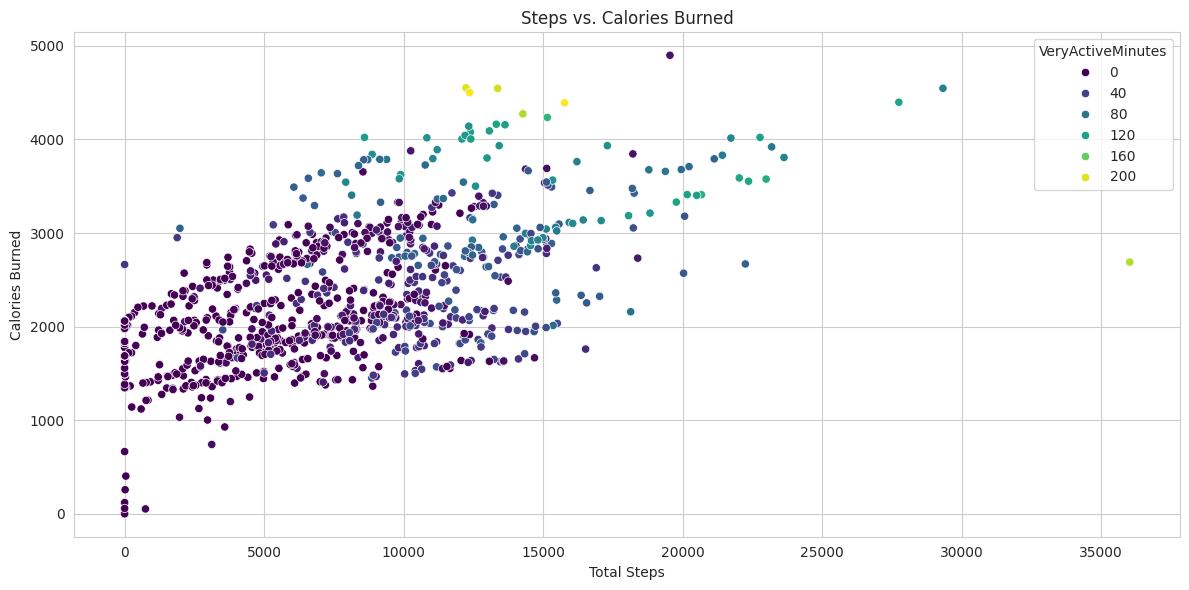

In [21]:
# ------------------------------------------------------------------------------
# 9. Steps vs. Calories Visualization
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=merged_df,
    x='TotalSteps',
    y='Calories',
    hue='VeryActiveMinutes',
    palette='viridis'
)
plt.title('Steps vs. Calories Burned')
plt.xlabel('Total Steps')
plt.ylabel('Calories Burned')
plt.grid(True)
plt.tight_layout()
plt.show()

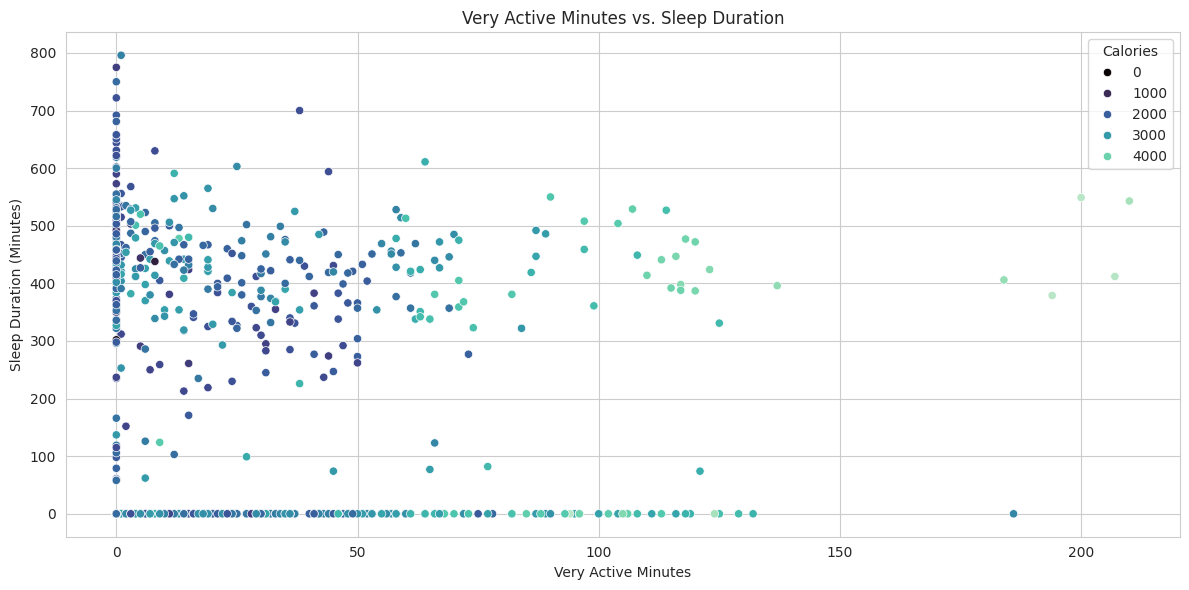

In [22]:
# ------------------------------------------------------------------------------
# 10. Very Active Minutes vs. Sleep Duration Visualization
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=merged_df,
    x='VeryActiveMinutes',
    y='TotalMinutesAsleep',
    hue='Calories',
    palette='mako'
)
plt.title('Very Active Minutes vs. Sleep Duration')
plt.xlabel('Very Active Minutes')
plt.ylabel('Sleep Duration (Minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

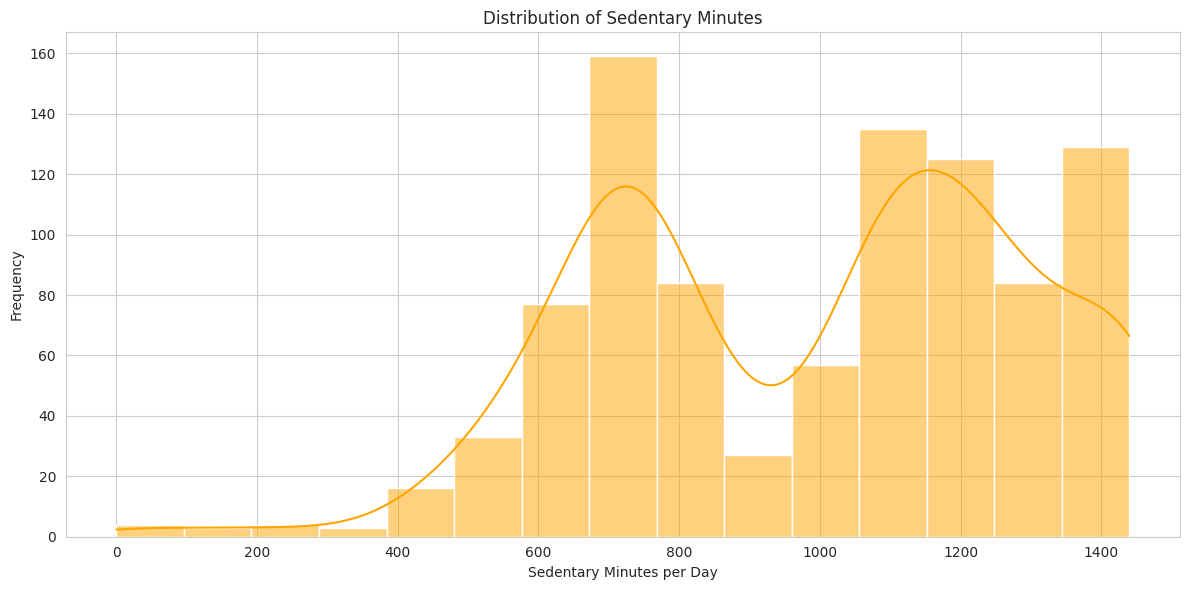

In [23]:
# ------------------------------------------------------------------------------
# 11. Sedentary Minutes Distribution
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(
    data=merged_df,
    x='SedentaryMinutes',
    kde=True,
    color='orange'
)
plt.title('Distribution of Sedentary Minutes')
plt.xlabel('Sedentary Minutes per Day')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-24-742acd70f645>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


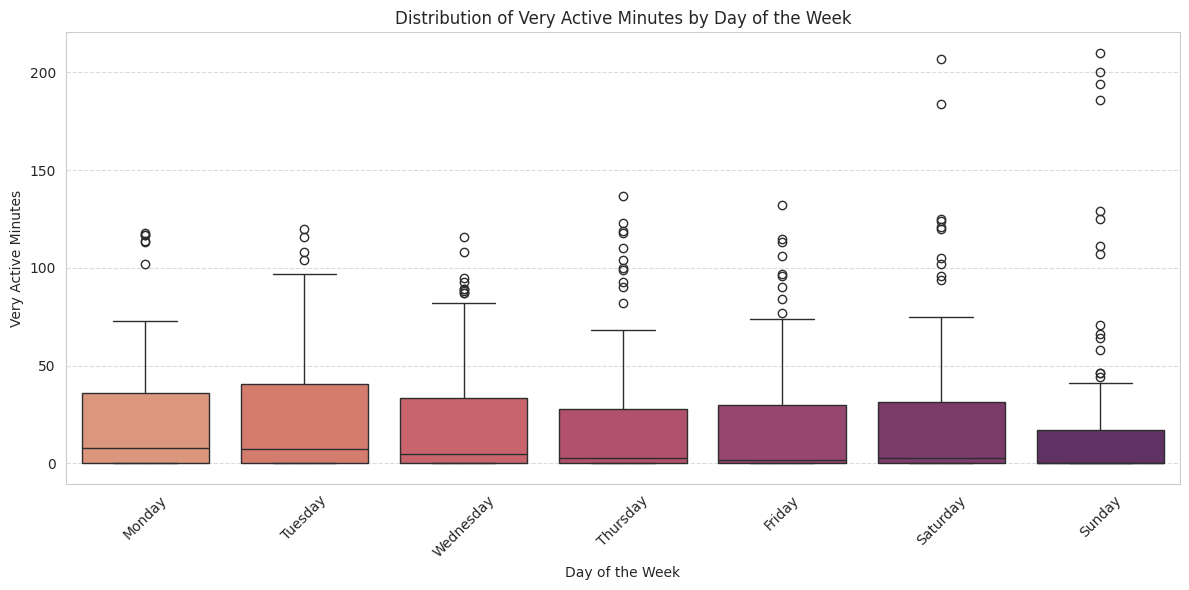

In [24]:
# ------------------------------------------------------------------------------
# 12. Boxplot: Distribution of Very Active Minutes by Day of the Week
# ------------------------------------------------------------------------------
# Convert 'ActivityDate' to day names with a specified order
merged_df['DayOfWeek'] = merged_df['ActivityDate'].dt.day_name()
cat_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
merged_df['DayOfWeek'] = pd.Categorical(merged_df['DayOfWeek'], categories=cat_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_df,
    x='DayOfWeek',
    y='VeryActiveMinutes',
    order=cat_order,
    palette='flare'
)
plt.title('Distribution of Very Active Minutes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Very Active Minutes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-25-177e352d89f5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_sleep, x='Id', y='TotalMinutesAsleep', palette='cool')


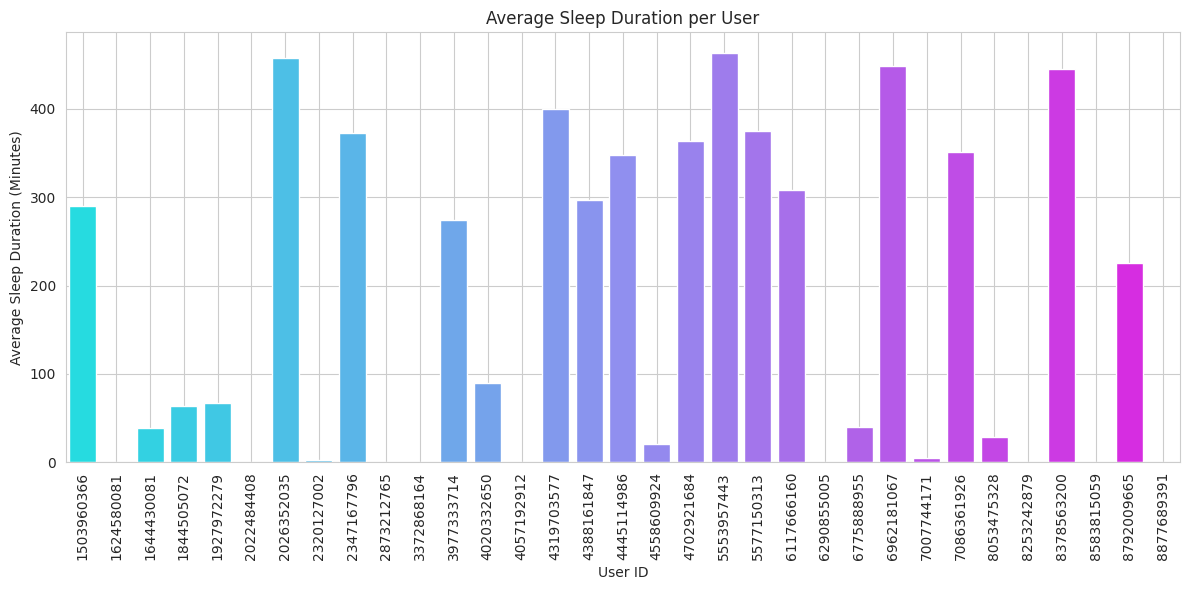

In [25]:
# ------------------------------------------------------------------------------
# 13. Additional Visualization: Average Sleep Duration per User
# ------------------------------------------------------------------------------
avg_sleep = merged_df.groupby('Id', as_index=False)['TotalMinutesAsleep'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sleep, x='Id', y='TotalMinutesAsleep', palette='cool')
plt.title('Average Sleep Duration per User')
plt.xlabel('User ID')
plt.ylabel('Average Sleep Duration (Minutes)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()